# Sieci Neuronowe (MLP)

Celem tego notatnika jest stworzenie, analiza i wizualizacja modelu sieci neuronowej (Multi-Layer Perceptron) do klasyfikacji gatunków muzycznych.

## Plan Notatnika:
1. **Przygotowanie Danych**: Wczytanie, czyszczenie (fix_data) i standaryzacja.
2. **Analiza i Trening Hiperparametrów**: Zbadanie wpływu architektury, learning rate solvera i regularyzacji na wynik.
3. **Wizualizacja Ewolucji i Końcowego Wyniku**: Ewolucja podczas kolejnych epok i skuteczność ostatecznego modelu.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
import os
import time

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

sns.set_theme(style="whitegrid", context="notebook", palette="deep")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14

## 1. Wczytanie i Naprawa Danych


In [2]:
def fix_data(df):
    feature_cols = [col for col in df.columns if col not in ['genre', 'filename']]
    
    for col in feature_cols:
        if df[col].dtype == 'object':
            # Usuwanie nawiasów i konwersja
            df[col] = df[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
        # Uzupełnianie ewentualnych braków średnią
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())
    
    return df

# Ścieżki do plików (zakładamy uruchomienie z folderu notebooks/)
train_path = '../data/processed/train_features.csv'
val_path = '../data/processed/val_features.csv'
test_path = '../data/processed/test_features.csv'

print("Wczytywanie danych...")
try:
    df_train = fix_data(pd.read_csv(train_path))
    df_val = fix_data(pd.read_csv(val_path))
    df_test = fix_data(pd.read_csv(test_path))
    print("Dane wczytane poprawnie.")
    print(f"Train shape: {df_train.shape} | Val shape: {df_val.shape} | Test shape: {df_test.shape}")
except FileNotFoundError:
    print("BŁĄD: Nie znaleziono plików! Sprawdź czy jesteś w folderze 'notebooks' i czy ścieżka '../data/processed/' jest poprawna.")
except Exception as e:
    print(f"BŁĄD podczas wczytywania: {e}")

Wczytywanie danych...
Dane wczytane poprawnie.
Train shape: (600, 46) | Val shape: (200, 46) | Test shape: (200, 46)


In [3]:
# Przygotowanie X i y
X_train = df_train.drop(columns=['genre', 'filename'], errors='ignore')
y_train = df_train['genre']

X_val = df_val.drop(columns=['genre', 'filename'], errors='ignore')
y_val = df_val['genre']

X_test = df_test.drop(columns=['genre', 'filename'], errors='ignore')
y_test = df_test['genre']

# Label Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)
classes = le.classes_

# Standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Liczba cech: {X_train.shape[1]}")
print(f"Klasy ({len(classes)}): {classes}")

Liczba cech: 44
Klasy (10): ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


## 2. Analiza i Wizualizacja Wpływu Hiperparametrów


### Szukanie Optymalnej Ilości i Wielkości Warstw

Rozpoczynam Etap 1: Badanie Architektury i Aktywacji...


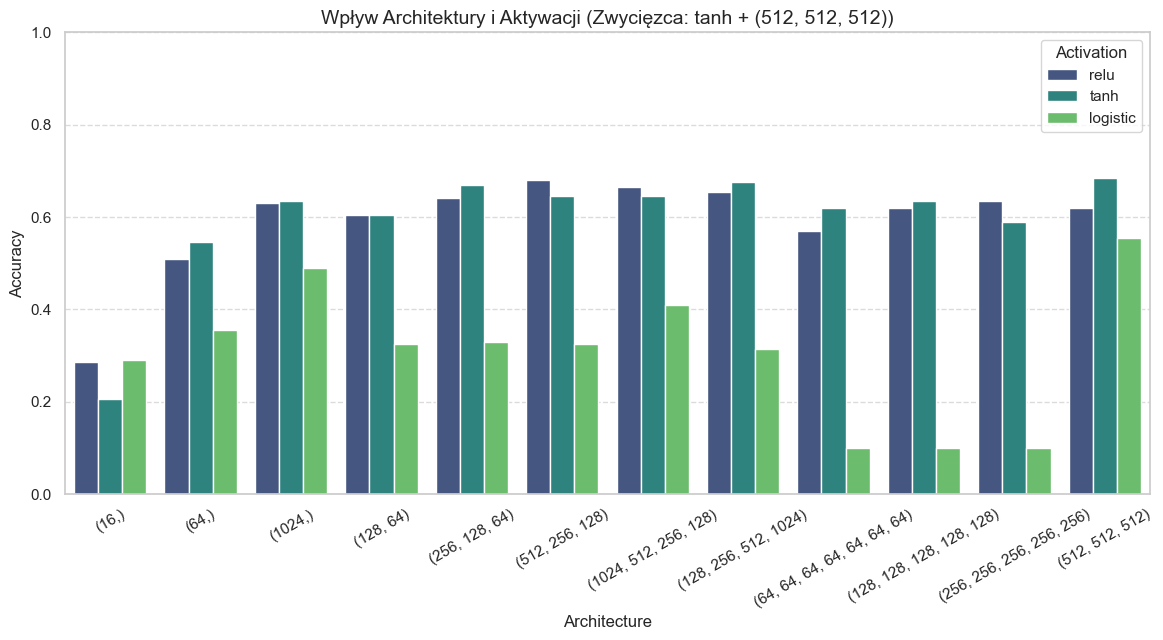


=== WYNIKI ETAPU 1 ===
   Activation           Architecture  Accuracy
23       tanh        (512, 512, 512)     0.685
5        relu        (512, 256, 128)     0.680
19       tanh  (128, 256, 512, 1024)     0.675
16       tanh         (256, 128, 64)     0.670
6        relu  (1024, 512, 256, 128)     0.665

>>> DO NASTĘPNEGO ETAPU PRZECHODZĄ: Architektura=(512, 512, 512), Aktywacja='tanh'


In [4]:
architectures = [
    (16,), (64,),           
    (1024,),                
    (128, 64),              
    (256, 128, 64,),         
    (512, 256, 128), 
    (1024, 512, 256, 128),
    (128, 256, 512, 1024),      
    tuple([64] * 7),
    tuple([128] * 5),
    tuple([256] * 5),
    tuple([512] * 3),
]
activations = ['relu', 'tanh', 'logistic']

results_stage1 = []

print("Rozpoczynam Etap 1: Badanie Architektury i Aktywacji...")

for act in activations:
    for arch in architectures:
        model = MLPClassifier(
            hidden_layer_sizes=arch,
            activation=act,
            solver='adam',
            learning_rate_init=0.001,
            max_iter=200,
            random_state=42,
            early_stopping=True
        )
        model.fit(X_train_scaled, y_train_enc)
        val_acc = model.score(X_val_scaled, y_val_enc)
        
        results_stage1.append({
            'Activation': act,
            'Architecture': str(arch),
            'Accuracy': val_acc
        })

# DataFrame z wynikami
df_stage1 = pd.DataFrame(results_stage1)

# Znalezienie najlepszej konfiguracji
best_result = df_stage1.loc[df_stage1['Accuracy'].idxmax()]
BEST_ARCH = eval(best_result['Architecture'])
BEST_ACT = best_result['Activation']

plt.figure(figsize=(14, 6))
sns.barplot(data=df_stage1, x='Architecture', y='Accuracy', hue='Activation', palette='viridis')
plt.title(f'Wpływ Architektury i Aktywacji (Zwycięzca: {BEST_ACT} + {BEST_ARCH})')
plt.ylim(0, 1.0)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"\n=== WYNIKI ETAPU 1 ===")
print(df_stage1.sort_values(by='Accuracy', ascending=False).head(5))
print(f"\n>>> DO NASTĘPNEGO ETAPU PRZECHODZĄ: Architektura={BEST_ARCH}, Aktywacja='{BEST_ACT}'")

In [ ]:
activations = ['relu', 'tanh', 'logistic']
depths = [1, 2, 3, 5, 7] 
widths = [32, 64, 128, 256, 512, 1024] 

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
axes = axes.flatten()

results_data = []

print("Rozpoczynam analizę architektury (Grid Search)...")
start_time = time.time()

for idx, act in enumerate(activations):
    ax = axes[idx]
    print(f"--> Przetwarzanie funkcji aktywacji: {act.upper()}...")
    
    for d in depths:
        means, stds = [], []
        
        for w in widths:
            acc_scores = []
            # Używamy 2 seedów dla uśrednienia wyniku
            for seed in [42, 123]:
                # Dodano early_stopping=True dla przyspieszenia
                model = MLPClassifier(hidden_layer_sizes=tuple([w]*d), activation=act,
                                      max_iter=150, random_state=seed, 
                                      early_stopping=True)
                model.fit(X_train_scaled, y_train_enc)
                acc_scores.append(model.score(X_val_scaled, y_val_enc))

            mean_acc = np.mean(acc_scores)
            std_acc = np.std(acc_scores)
            
            means.append(mean_acc)
            stds.append(std_acc)
            
            # ZAPISYWANIE WYNIKÓW DO LISTY
            results_data.append({
                'Aktywacja': act,
                'Warstwy (Głębokość)': d,
                'Neurony (Szerokość)': w,
                'Średnie Accuracy': mean_acc,
                'Odchylenie Std': std_acc
            })

        # Rysowanie linii z cieniem
        line, = ax.plot(widths, means, marker='o', label=f'{d} warstwy')
        ax.fill_between(widths,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        alpha=0.2, color=line.get_color())

    ax.set_title(f'Aktywacja: {act.upper()}')
    ax.set_xlabel('Liczba neuronów w warstwie')
    ax.set_ylabel('Accuracy (Walidacja)')
    ax.legend(title="Głębokość")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\n" + "="*40)
print("RANKING NAJLEPSZYCH KONFIGURACJI")
print("="*40)

df_results = pd.DataFrame(results_data)

df_results = df_results.sort_values(by='Średnie Accuracy', ascending=False).reset_index(drop=True)

print(df_results.head(15))

best_row = df_results.iloc[0]
print(f"\n>>> ZWYCIĘZCA: Aktywacja={best_row['Aktywacja']}, "
      f"Warstwy={best_row['Warstwy (Głębokość)']}, "
      f"Neurony={best_row['Neurony (Szerokość)']} "
      f"z wynikiem {best_row['Średnie Accuracy']:.4f}")

Rozpoczynam analizę architektury (Grid Search)...
--> Przetwarzanie funkcji aktywacji: RELU...


### Sukanie optymalnego solvera i LR

Rozpoczynam Etap 2 dla sieci (512, 512, 512) (tanh)...


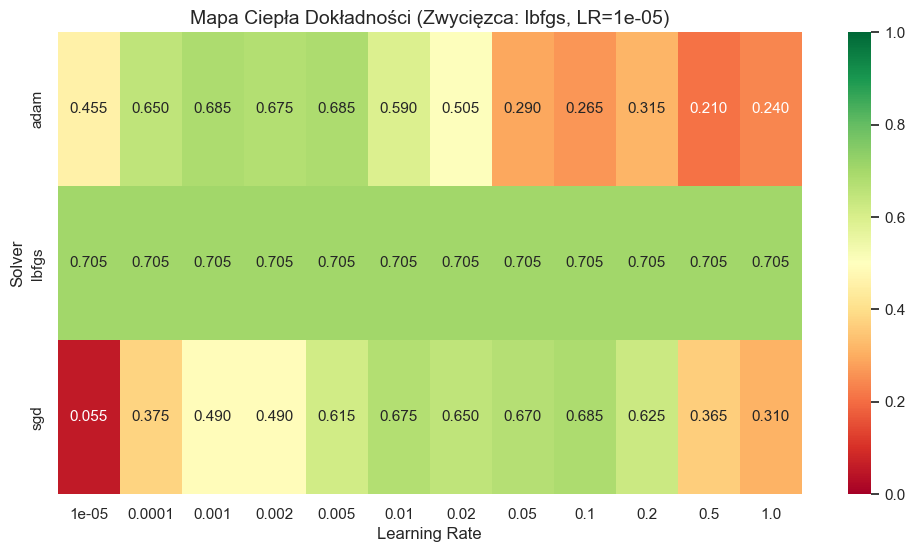


>>> ZWYCIĘZCA ETAPU 2: Solver=lbfgs, LR=1e-05


In [5]:
current_arch = BEST_ARCH
current_act = BEST_ACT

# 3 solvery dostępne w sklearn 
solvers = ['adam', 'sgd', 'lbfgs'] 
lrs = [0.00001, 0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]

results_stage2 = []

print(f"Rozpoczynam Etap 2 dla sieci {current_arch} ({current_act})...")

for solv in solvers:
    for lr in lrs:
        # LBFGS nie obsługuje early_stopping i minibatchy, SGD wymaga więcej epok
        es = True if solv != 'lbfgs' else False
        iters = 500 if solv == 'sgd' else 200
        
        try:
            model = MLPClassifier(
                hidden_layer_sizes=current_arch,
                activation=current_act,
                solver=solv,
                learning_rate_init=lr,
                max_iter=iters,
                random_state=42,
                early_stopping=es
            )
            model.fit(X_train_scaled, y_train_enc)
            val_acc = model.score(X_val_scaled, y_val_enc)
            
            results_stage2.append({
                'Solver': solv,
                'Learning Rate': lr,
                'Accuracy': val_acc
            })
        except Exception as e:
            print(f"Pominięto {solv} z LR {lr}: {e}")

df_stage2 = pd.DataFrame(results_stage2)

# Znalezienie najlepszej konfiguracji
best_result_2 = df_stage2.loc[df_stage2['Accuracy'].idxmax()]
BEST_SOLVER = best_result_2['Solver']
BEST_LR = best_result_2['Learning Rate']

pivot_table = df_stage2.pivot(index='Solver', columns='Learning Rate', values='Accuracy')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='RdYlGn', vmin=0, vmax=1)
plt.title(f'Mapa Ciepła Dokładności (Zwycięzca: {BEST_SOLVER}, LR={BEST_LR})')
plt.show()

print(f"\n>>> ZWYCIĘZCA ETAPU 2: Solver={BEST_SOLVER}, LR={BEST_LR}")

### Szukanie Optymajnej Alphy

Rozpoczynam Etap 3 (Fine-tuning) dla parametrów z poprzednich etapów...


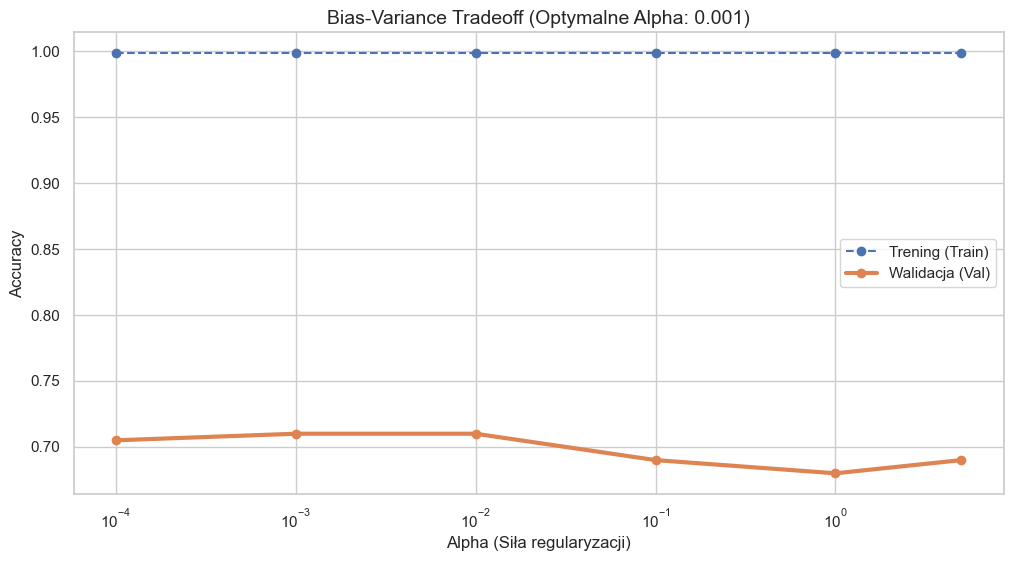


=== WYNIKI ETAPU 3 ===
    Alpha  Train Accuracy  Val Accuracy
0  0.0001        0.998333         0.705
1  0.0010        0.998333         0.710
2  0.0100        0.998333         0.710
3  0.1000        0.998333         0.690
4  1.0000        0.998333         0.680
5  5.0000        0.998333         0.690

>>> ZWYCIĘSKI ZESTAW PARAMETRÓW: 
Arch=(512, 512, 512), Act=tanh, Solver=lbfgs, LR=1e-05, Alpha=0.001


In [6]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0]

results_stage3 = []

print(f"Rozpoczynam Etap 3 (Fine-tuning) dla parametrów z poprzednich etapów...")

for alpha in alphas:
    model = MLPClassifier(
        hidden_layer_sizes=BEST_ARCH,
        activation=BEST_ACT,
        solver=BEST_SOLVER,
        learning_rate_init=BEST_LR,
        alpha=alpha,
        max_iter=200,
        random_state=42
    )
    model.fit(X_train_scaled, y_train_enc)
    
    train_acc = model.score(X_train_scaled, y_train_enc)
    val_acc = model.score(X_val_scaled, y_val_enc)
    
    results_stage3.append({
        'Alpha': alpha,
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc
    })

df_stage3 = pd.DataFrame(results_stage3)

# Najlepsze Alpha
BEST_ALPHA = df_stage3.loc[df_stage3['Val Accuracy'].idxmax()]['Alpha']

plt.figure(figsize=(12, 6))
plt.plot(df_stage3['Alpha'], df_stage3['Train Accuracy'], marker='o', label='Trening (Train)', linestyle='--')
plt.plot(df_stage3['Alpha'], df_stage3['Val Accuracy'], marker='o', label='Walidacja (Val)', linewidth=3)
plt.xscale('log')
plt.xlabel('Alpha (Siła regularyzacji)')
plt.ylabel('Accuracy')
plt.title(f'Bias-Variance Tradeoff (Optymalne Alpha: {BEST_ALPHA})')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n=== WYNIKI ETAPU 3 ===")
print(df_stage3)
print(f"\n>>> ZWYCIĘSKI ZESTAW PARAMETRÓW: \nArch={BEST_ARCH}, Act={BEST_ACT}, Solver={BEST_SOLVER}, LR={BEST_LR}, Alpha={BEST_ALPHA}")

### Confiusion Matrix dla Różnie Dobrych Modeli

Trenowanie modelu: Słaby (Underfit)...
Trenowanie modelu: Średni (Standard)...
Trenowanie modelu: Najlepszy (Tuned)...


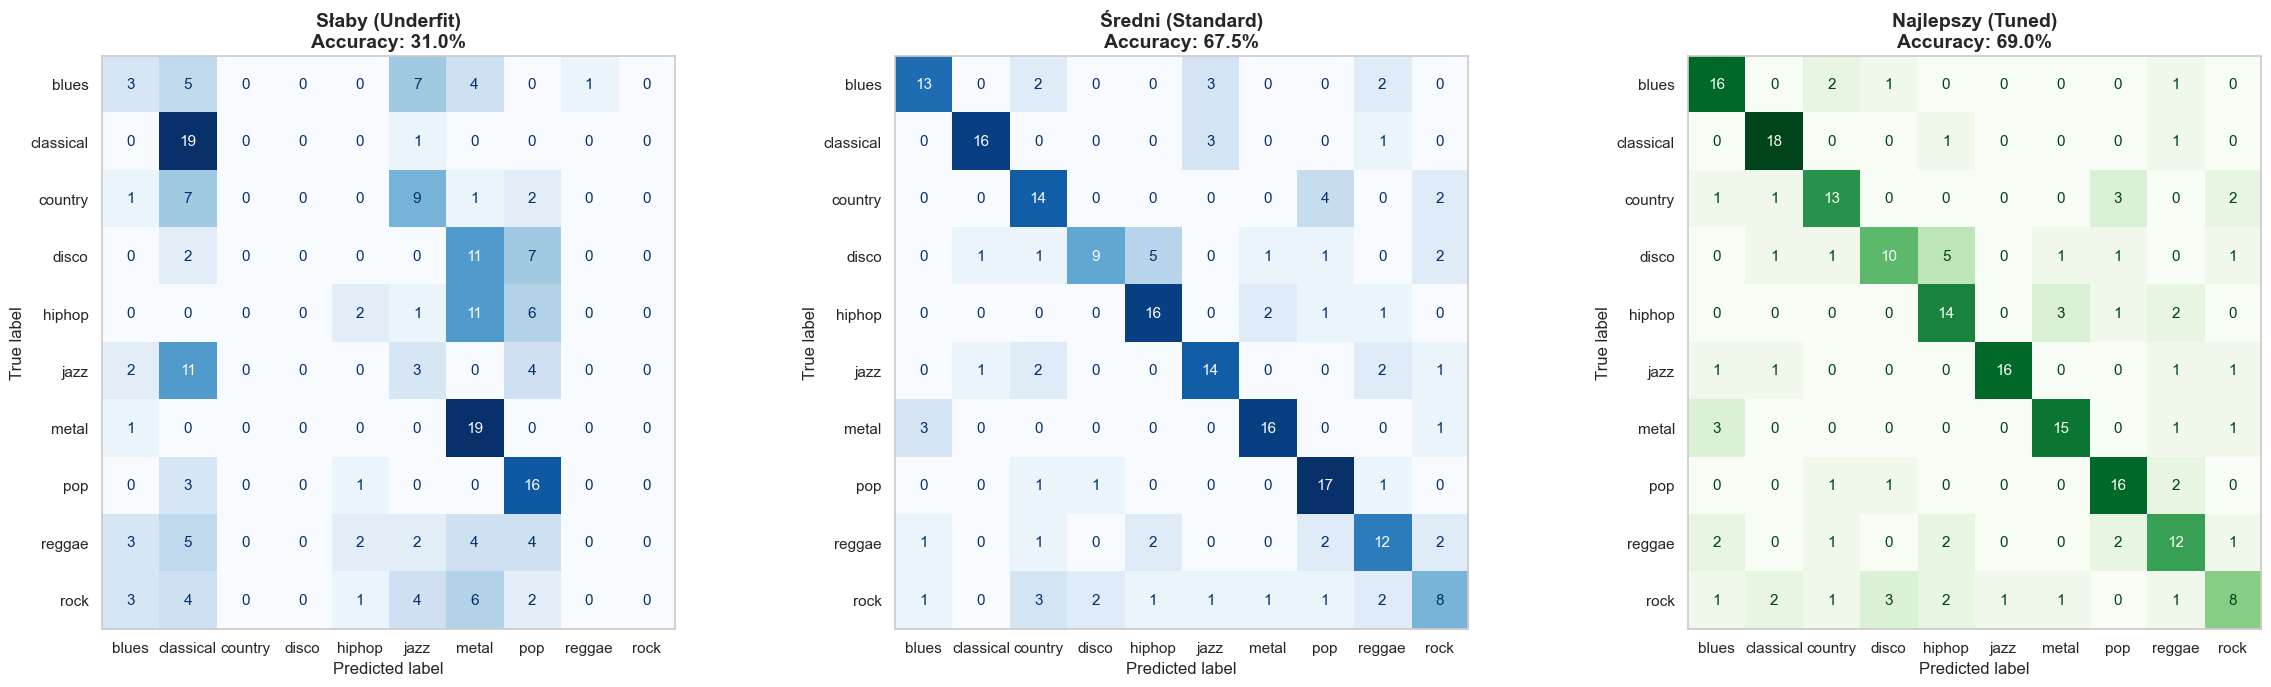

In [9]:
models_comp = [
    ("Słaby (Underfit)", MLPClassifier(hidden_layer_sizes=(8,), max_iter=50, random_state=42)),
    ("Średni (Standard)", MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)),
    ("Najlepszy (Tuned)", MLPClassifier(
        hidden_layer_sizes=BEST_ARCH, activation=BEST_ACT, 
        solver=BEST_SOLVER, learning_rate_init=BEST_LR, 
        alpha=BEST_ALPHA, max_iter=400, random_state=42
    ))
]

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for i, (name, model) in enumerate(models_comp):
    print(f"Trenowanie modelu: {name}...")
    model.fit(X_train_scaled, y_train_enc)
    
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test_enc, y_pred)
    
    ConfusionMatrixDisplay.from_predictions(
        y_test_enc, y_pred, 
        display_labels=classes, 
        cmap='Blues' if i < 2 else 'Greens', # Najlepszy model na zielono
        ax=axes[i], colorbar=False
    )
    axes[i].set_title(f"{name}\nAccuracy: {acc*100:.1f}%", fontsize=14, fontweight='bold')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

## 3. Wybór i Przedstawienie Ostatecznego Modelu i Ewolucja Błędu

In [30]:
# Konfiguracja finalnego modelu
final_model = MLPClassifier(
    hidden_layer_sizes=BEST_ARCH,
    activation=BEST_ACT,
    solver=BEST_SOLVER,
    learning_rate_init=BEST_LR,
    alpha=BEST_ALPHA,
    random_state=42,
    warm_start=True,
    max_iter=1
)

n_epochs = 250
history = {'loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
cm_snapshots = {}
snapshot_epochs = [1, 10, 50, 100, 249]
unique_classes = np.unique(y_train_enc)

print(f"Rozpoczynam szczegółowy trening zwycięskiego modelu przez {n_epochs} epok...")

for epoch in range(n_epochs):
    # Krok uczenia
    final_model.partial_fit(X_train_scaled, y_train_enc, classes=unique_classes)
    
    # Logowanie metryk
    history['loss'].append(final_model.loss_)
    history['train_acc'].append(final_model.score(X_train_scaled, y_train_enc))
    
    # Walidacja ręczna
    y_val_prob = final_model.predict_proba(X_val_scaled)
    val_loss = log_loss(y_val_enc, y_val_prob)
    val_acc = final_model.score(X_val_scaled, y_val_enc)
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Zapis macierzy pomyłek
    if (epoch + 1) in snapshot_epochs:
        preds = final_model.predict(X_val_scaled)
        cm_snapshots[epoch + 1] = confusion_matrix(y_val_enc, preds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss
ax1.plot(history['loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss', linestyle='--')
ax1.set_title('Ewolucja Błędu (Loss)')
ax1.legend()

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc', linestyle='--')
ax2.set_title('Ewolucja Skuteczności (Accuracy)')
ax2.legend()
plt.show()

num_snaps = len(cm_snapshots)
fig, axes = plt.subplots(1, num_snaps, figsize=(4*num_snaps, 4))
for i, (ep, cm) in enumerate(cm_snapshots.items()):
    sns.heatmap(cm, annot=False, cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"Epoka {ep}")
plt.tight_layout()
plt.show()

print("\n=== OSTATECZNY WYNIK NA ZBIORZE TESTOWYM ===")
test_acc = final_model.score(X_test_scaled, y_test_enc)
print(f"Final Test Accuracy: {test_acc:.4f}")

y_pred_test = final_model.predict(X_test_scaled)
print(classification_report(y_test_enc, y_pred_test, target_names=classes))

Rozpoczynam szczegółowy trening zwycięskiego modelu przez 250 epok...


AttributeError: This 'MLPClassifier' has no attribute 'partial_fit'

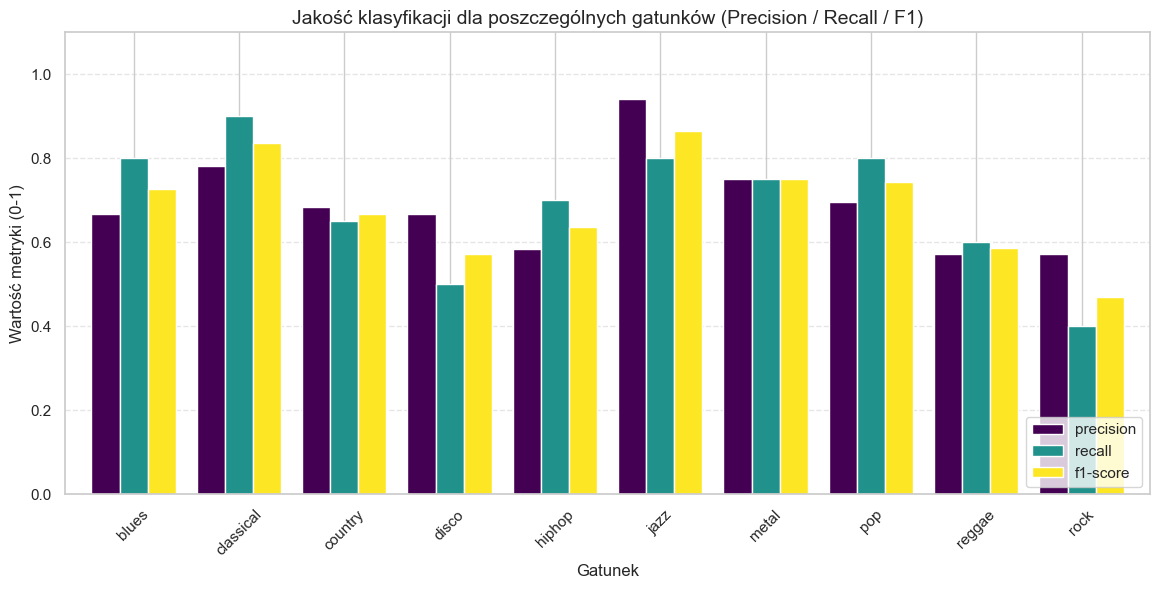

Interpretacja:
- Wysoki słupek 'Precision' oznacza, że model rzadko myli inne gatunki z tym gatunkiem.
- Wysoki słupek 'Recall' oznacza, że model znajduje większość utworów tego gatunku.


In [12]:
from sklearn.metrics import classification_report

best_model = models_comp[2][1] 
y_pred_final = best_model.predict(X_test_scaled)

report_dict = classification_report(y_test_enc, y_pred_final, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

df_metrics = df_report.iloc[:-3, :3]

df_metrics.plot(kind='bar', figsize=(14, 6), width=0.8, colormap='viridis')
plt.title("Jakość klasyfikacji dla poszczególnych gatunków (Precision / Recall / F1)", fontsize=14)
plt.ylabel("Wartość metryki (0-1)")
plt.xlabel("Gatunek")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

print("Interpretacja:")
print("- Wysoki słupek 'Precision' oznacza, że model rzadko myli inne gatunki z tym gatunkiem.")
print("- Wysoki słupek 'Recall' oznacza, że model znajduje większość utworów tego gatunku.")

In [9]:
### KOMÓRKA: DIAGNOSTYKA POJEDYNCZEJ EPOKI ###
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- KONFIGURACJA ---
target_epoch = 120  # <--- TU WPISZ NR EPOKI, KTÓRĄ CHCESZ ZBADAĆ

# 1. Inicjalizacja modelu (pustego)
model_snapshot = MLPClassifier(
    hidden_layer_sizes=BEST_ARCH,
    activation=BEST_ACT,
    solver=BEST_SOLVER,
    learning_rate_init=BEST_LR,
    alpha=BEST_ALPHA,
    random_state=42,
    warm_start=True, # Ważne: pozwala na douczanie
    max_iter=1,
)

unique_classes = np.unique(y_train_enc)

# 2. Pętla treningowa doprowadzająca model do wybranej epoki
print(f"Symulacja treningu do epoki {target_epoch}...")

for epoch in range(target_epoch):
    model_snapshot.partial_fit(X_train_scaled, y_train_enc, classes=unique_classes)
    # Opcjonalnie: print postępu co 10 epok
    if (epoch + 1) % 10 == 0:
        print(f"-> Ukończono epokę {epoch + 1}")

# 3. Ewaluacja w tym konkretnym momencie czasu
y_pred_snapshot = model_snapshot.predict(X_val_scaled)
acc_snapshot = accuracy_score(y_val_enc, y_pred_snapshot)

# 4. Wizualizacja
fig, ax = plt.subplots(figsize=(10, 8))

ConfusionMatrixDisplay.from_predictions(
    y_val_enc, 
    y_pred_snapshot,
    display_labels=classes,
    cmap='Blues',
    ax=ax,
    colorbar=False
)

ax.set_title(f"Stan wiedzy modelu w epoce {target_epoch}\nAccuracy: {acc_snapshot*100:.2f}%", fontsize=14)
plt.grid(False)
plt.show()

Symulacja treningu do epoki 120...


AttributeError: This 'MLPClassifier' has no attribute 'partial_fit'